APS360 Project - Baseline Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import time
import math
import os
from torch.utils.data import DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# resize all to 244 by 244
combined_data_val = '/content/gdrive/MyDrive/APS360/combined_data/valid'
combined_data_tra = '/content/gdrive/MyDrive/APS360/combined_data/train'
combined_data_tes = '/content/gdrive/MyDrive/APS360/combined_data/test'

transform = transforms.Compose([
    transforms.Resize((244,244)),
    transforms.Grayscale(num_output_channels=1),  # convert to grayscale with 1 channels
    transforms.ToTensor()
])

combined_data_v = torchvision.datasets.ImageFolder(combined_data_val, transform=transform)
combined_data_tr = torchvision.datasets.ImageFolder(combined_data_tra, transform=transform)
combined_data_te = torchvision.datasets.ImageFolder(combined_data_tes, transform=transform)

In [ ]:
# resize all to 244 by 244
small_data_val = '/content/gdrive/MyDrive/APS360/Dataset3_small_data/valid'
small_data_tra = '/content/gdrive/MyDrive/APS360/Dataset3_small_data/train'

transform = transforms.Compose([
    transforms.Resize((244,244)),
    transforms.Grayscale(num_output_channels=1),  # convert to grayscale with 1 channels
    transforms.ToTensor()
])

small_data_v = torchvision.datasets.ImageFolder(small_data_val, transform=transform)
small_data_t = torchvision.datasets.ImageFolder(small_data_tra, transform=transform)

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/APS360/Dataset3_small_data/valid'

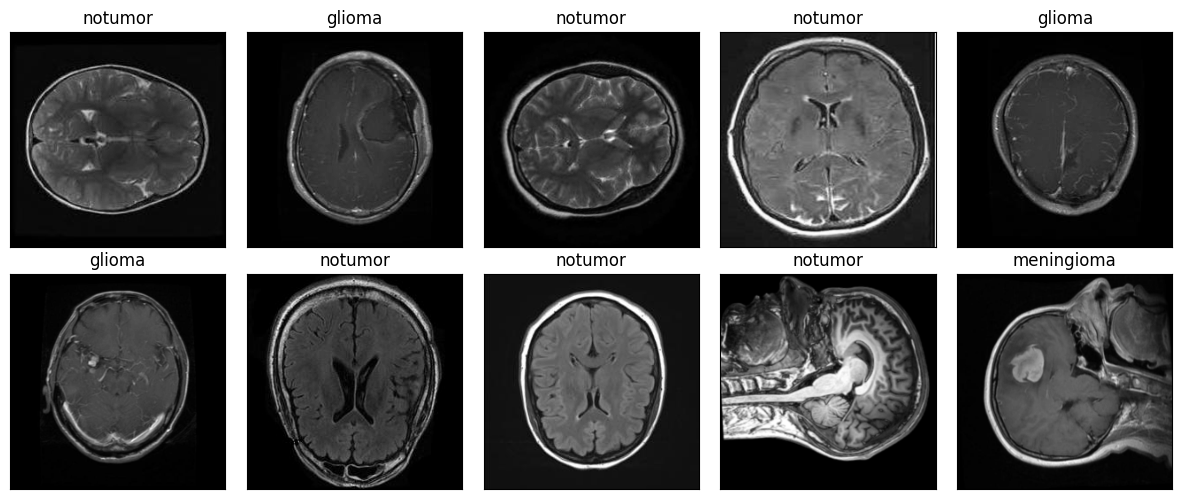

In [ ]:
# modified code from an online source to print out images
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

# assuming dataset3_bal_val is defined and loaded correctly
batch_size = 10  # Set your desired batch size
dataloader = DataLoader(combined_data_v, batch_size=batch_size, shuffle=True)

dataiter = iter(dataloader)  # create iterator from dataloader
images, labels = next(dataiter)  # fetch a batch of images and labels
images = images.numpy()

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15, 6))  # Adjust figure size if needed
gs = fig.add_gridspec(2, 5, wspace=0.1, hspace=0.1)  # Adjust wspace and hspace

for idx in np.arange(len(images)):  # Iterate over the images in the batch
    ax = fig.add_subplot(gs[idx // 5, idx % 5])  # GridSpec for better control
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx].item()])  # Use .item() to get the label as an integer
    ax.set_xticks([])  # Remove x ticks
    ax.set_yticks([])  # Remove y ticks

plt.show()

In [ ]:
use_cuda = True

In [ ]:
class baselineANN(nn.Module):
    def __init__(self, num_classes):
        super(baselineANN, self).__init__()
        self.name = "baselineANN"
        self.layer1 = nn.Linear(1 * 244 * 244, 100)  # Adjust input features to match reshaped input
        #self.pool = nn.MaxPool2d(2, 2)
        self.layer2 = nn.Linear(100, 50)
        self.layer3 = nn.Linear(50, num_classes)

    def forward(self, img):
        # Reshape the input for the convolutional layer
        activation1 = self.layer1(img.view(-1, 1 * 244 * 244))  # Flatten input for linear layer
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = F.relu(activation2)
        output = self.layer3(activation2)
        return output

In [ ]:
# helper function
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:

      # move data to GPU if available
      if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
      output = model(imgs)

      # select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]
    return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

# training function
# from tutorial 3a + lab 2:
def train_baseline_model(model, data1, data2, batch_size=64, num_workers=2, num_epochs=1, learning_rate=0.01):
    torch.manual_seed(10)

    if use_cuda and torch.cuda.is_available():
        model.cuda()

    train_loader = torch.utils.data.DataLoader(data1, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_loader = torch.utils.data.DataLoader(data2, batch_size=batch_size, num_workers=num_workers, shuffle=True)


    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), learning_rate)

    # train_acc, val_acc = [], []
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    # training
    print('Started Training')
    start_time = time.time()
    for epoch in range(num_epochs):

        for imgs, labels in train_loader:

            #############################################
            # to enable GPU usage
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        train_acc[epoch] = (get_accuracy(model, train_loader)) # compute training accuracy
        val_acc[epoch] = (get_accuracy(model, val_loader))  # compute validation accuracy


        # save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
        print(("Epoch {0}: Train accuracy: {1}, Validation accuracy: {2}").format(
                   epoch + 1,
                   train_acc[epoch],
                   val_acc[epoch]))


    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    epochs = np.arange(1, num_epochs + 1)

    # plotting
    plt.title("Training vs. Validation Accuracy")
    plt.plot(epochs, train_acc, label="Training accuracy",color='blue')
    plt.plot(epochs, val_acc, label="Validation accuracy",color='orange')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    print("Final training accuracy: {}".format(train_acc[-1]))
    print("Final validation accuracy: {}".format(val_acc[-1]))

Using original dataset 3:

Started Training
Finished Training
Total time elapsed: 2671.57 seconds


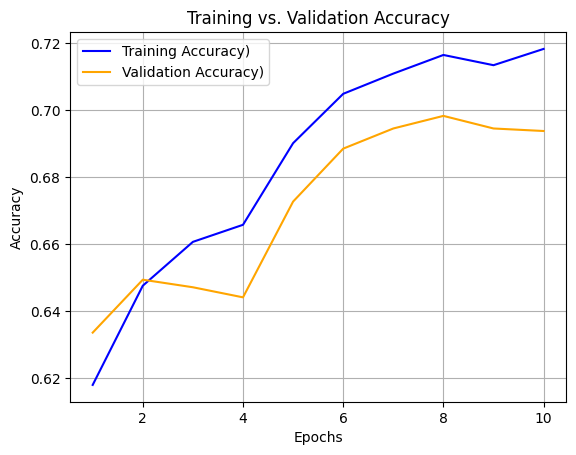

Final Training Accuracy: 0.7182601880877743
Final Validation Accuracy: 0.6937547027840482


In [ ]:
baseline_model = baselineANN()
train_baseline_model(baseline_model, data1=dataset5, data2=dataset4, batch_size=256, num_epochs=10, learning_rate=0.001)

Utilizing balanced dataset 3:

Started Training
Epoch 1: Train accuracy: 0.46567398119122255, Validation accuracy: 0.44620015048908956
Epoch 2: Train accuracy: 0.46371473354231973, Validation accuracy: 0.43792325056433407
Epoch 3: Train accuracy: 0.47656739811912224, Validation accuracy: 0.45899172310007524
Epoch 4: Train accuracy: 0.4827586206896552, Validation accuracy: 0.4672686230248307
Epoch 5: Train accuracy: 0.4800156739811912, Validation accuracy: 0.4672686230248307
Epoch 6: Train accuracy: 0.4901253918495298, Validation accuracy: 0.5018811136192626
Epoch 7: Train accuracy: 0.48667711598746083, Validation accuracy: 0.5063957863054929
Epoch 8: Train accuracy: 0.49318181818181817, Validation accuracy: 0.49811888638073737
Epoch 9: Train accuracy: 0.4973354231974922, Validation accuracy: 0.510910458991723
Epoch 10: Train accuracy: 0.4955329153605016, Validation accuracy: 0.5026335590669676
Epoch 11: Train accuracy: 0.4962382445141066, Validation accuracy: 0.510158013544018
Epoch 12: Train accuracy: 0.50282131661

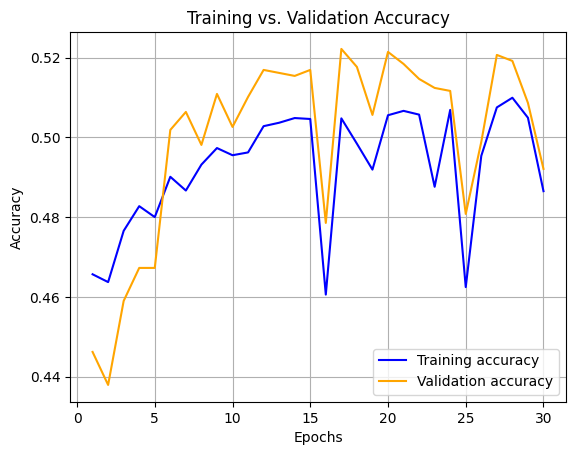

Final training accuracy: 0.4865203761755486
Final validation accuracy: 0.49209932279909707


In [ ]:
baseline_model = baselineANN()
train_baseline_model(baseline_model, data1=dataset3_bal_tra, data2=dataset3_bal_val, batch_size=256, num_epochs=30, learning_rate=0.001)

Started Training
Epoch 1: Train accuracy: 0.6695924764890282, Validation accuracy: 0.6696764484574869
Epoch 2: Train accuracy: 0.7130094043887147, Validation accuracy: 0.7208427389014297
Epoch 3: Train accuracy: 0.7640282131661442, Validation accuracy: 0.7614747930775019
Epoch 4: Train accuracy: 0.8087774294670846, Validation accuracy: 0.7900677200902935
Epoch 5: Train accuracy: 0.8412225705329154, Validation accuracy: 0.8088788562829194
Epoch 6: Train accuracy: 0.8462382445141066, Validation accuracy: 0.801354401805869
Epoch 7: Train accuracy: 0.8239811912225705, Validation accuracy: 0.8073739653875094
Epoch 8: Train accuracy: 0.8510971786833855, Validation accuracy: 0.7795334838224228
Epoch 9: Train accuracy: 0.9038401253918495, Validation accuracy: 0.8299473288186606
Epoch 10: Train accuracy: 0.8792319749216301, Validation accuracy: 0.8269375470278405
Epoch 11: Train accuracy: 0.8943573667711598, Validation accuracy: 0.8224228743416102
Epoch 12: Train accuracy: 0.9325235109717869, V

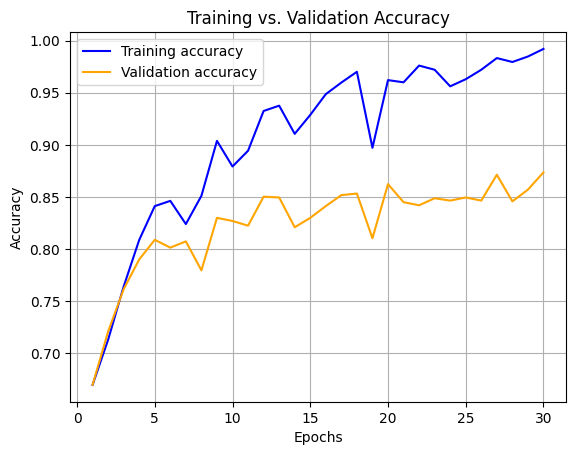

Final training accuracy: 0.9920846394984326
Final validation accuracy: 0.873589164785553


In [ ]:
baseline_model = baselineANN(num_classes=4)
train_baseline_model(baseline_model, data1=dataset3_bal_tra, data2=dataset3_bal_val, batch_size=128, num_epochs=30, learning_rate=0.0025)

Started Training
Epoch 1: Train accuracy: 0.3383228840125392, Validation accuracy: 0.3363431151241535
Epoch 2: Train accuracy: 0.4394984326018809, Validation accuracy: 0.43491346877351394
Epoch 3: Train accuracy: 0.40940438871473356, Validation accuracy: 0.38073739653875094
Epoch 4: Train accuracy: 0.436128526645768, Validation accuracy: 0.4251316779533484
Epoch 5: Train accuracy: 0.45195924764890283, Validation accuracy: 0.43867569601203915
Epoch 6: Train accuracy: 0.43268025078369904, Validation accuracy: 0.417607223476298
Epoch 7: Train accuracy: 0.4561128526645768, Validation accuracy: 0.44168547780285927
Epoch 8: Train accuracy: 0.34788401253918494, Validation accuracy: 0.3220466516177577
Epoch 9: Train accuracy: 0.45227272727272727, Validation accuracy: 0.436418359668924
Epoch 10: Train accuracy: 0.45940438871473355, Validation accuracy: 0.4431903686982694
Epoch 11: Train accuracy: 0.4014890282131661, Validation accuracy: 0.36418359668924005
Epoch 12: Train accuracy: 0.4560344827

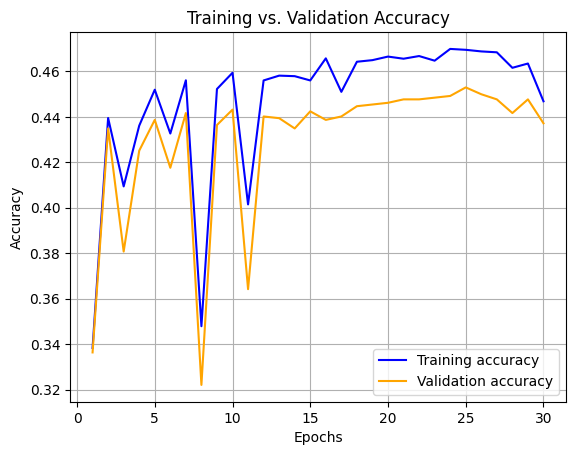

Final training accuracy: 0.4468652037617555
Final validation accuracy: 0.43717080511662904


In [ ]:
baseline_model = baselineANN(num_classes=4)
train_baseline_model(baseline_model, data1=dataset3_bal_tra, data2=dataset3_bal_val, batch_size=128, num_epochs=30, learning_rate=0.0025)

Utilizing a smaller dataset 3:

Started Training
Epoch 1: Train accuracy: 0.325, Validation accuracy: 0.275
Epoch 2: Train accuracy: 0.475, Validation accuracy: 0.425
Epoch 3: Train accuracy: 0.4, Validation accuracy: 0.3
Epoch 4: Train accuracy: 0.45, Validation accuracy: 0.3
Epoch 5: Train accuracy: 0.55, Validation accuracy: 0.3
Epoch 6: Train accuracy: 0.7, Validation accuracy: 0.35
Epoch 7: Train accuracy: 0.7, Validation accuracy: 0.475
Epoch 8: Train accuracy: 0.725, Validation accuracy: 0.6
Epoch 9: Train accuracy: 0.725, Validation accuracy: 0.525
Epoch 10: Train accuracy: 0.725, Validation accuracy: 0.4
Epoch 11: Train accuracy: 0.725, Validation accuracy: 0.275
Epoch 12: Train accuracy: 0.725, Validation accuracy: 0.325
Epoch 13: Train accuracy: 0.725, Validation accuracy: 0.475
Epoch 14: Train accuracy: 0.725, Validation accuracy: 0.5
Epoch 15: Train accuracy: 0.725, Validation accuracy: 0.5
Epoch 16: Train accuracy: 0.725, Validation accuracy: 0.475
Epoch 17: Train accuracy: 0.725, Validation accuracy: 0

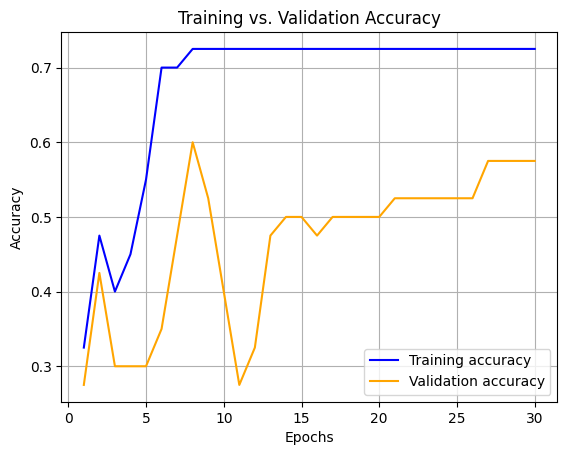

Final training accuracy: 0.725
Final validation accuracy: 0.575


In [ ]:
baseline_model = baselineANN()
train_baseline_model(baseline_model, data1=dataset3_tra, data2=dataset3_val, batch_size=128, num_epochs=30, learning_rate=0.001)

Started Training
Epoch 1: Train accuracy: 0.45, Validation accuracy: 0.275
Epoch 2: Train accuracy: 0.475, Validation accuracy: 0.525
Epoch 3: Train accuracy: 0.45, Validation accuracy: 0.3
Epoch 4: Train accuracy: 0.475, Validation accuracy: 0.25
Epoch 5: Train accuracy: 0.45, Validation accuracy: 0.275
Epoch 6: Train accuracy: 0.45, Validation accuracy: 0.325
Epoch 7: Train accuracy: 0.45, Validation accuracy: 0.45
Epoch 8: Train accuracy: 0.475, Validation accuracy: 0.525
Epoch 9: Train accuracy: 0.475, Validation accuracy: 0.5
Epoch 10: Train accuracy: 0.475, Validation accuracy: 0.5
Epoch 11: Train accuracy: 0.475, Validation accuracy: 0.5
Epoch 12: Train accuracy: 0.475, Validation accuracy: 0.5
Epoch 13: Train accuracy: 0.475, Validation accuracy: 0.5
Epoch 14: Train accuracy: 0.475, Validation accuracy: 0.5
Epoch 15: Train accuracy: 0.475, Validation accuracy: 0.5
Epoch 16: Train accuracy: 0.475, Validation accuracy: 0.5
Epoch 17: Train accuracy: 0.475, Validation accuracy: 0.5

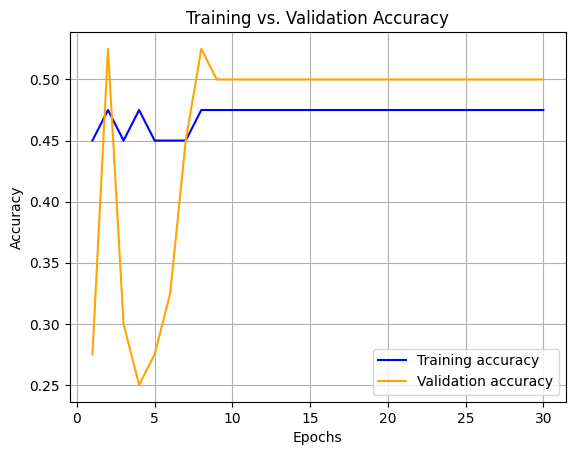

Final training accuracy: 0.475
Final validation accuracy: 0.5


In [ ]:
baseline_model = baselineANN()
train_baseline_model(baseline_model, data1=dataset3_tra, data2=dataset3_val, batch_size=4, num_epochs=30, learning_rate=0.001)

Started Training
Epoch 1: Train accuracy: 0.25, Validation accuracy: 0.25
Epoch 2: Train accuracy: 0.525, Validation accuracy: 0.35
Epoch 3: Train accuracy: 0.625, Validation accuracy: 0.475
Epoch 4: Train accuracy: 0.7, Validation accuracy: 0.625
Epoch 5: Train accuracy: 0.7, Validation accuracy: 0.6
Epoch 6: Train accuracy: 0.625, Validation accuracy: 0.6
Epoch 7: Train accuracy: 0.625, Validation accuracy: 0.475
Epoch 8: Train accuracy: 0.55, Validation accuracy: 0.375
Epoch 9: Train accuracy: 0.55, Validation accuracy: 0.35
Epoch 10: Train accuracy: 0.6, Validation accuracy: 0.325
Epoch 11: Train accuracy: 0.575, Validation accuracy: 0.275
Epoch 12: Train accuracy: 0.625, Validation accuracy: 0.4
Epoch 13: Train accuracy: 0.625, Validation accuracy: 0.5
Epoch 14: Train accuracy: 0.625, Validation accuracy: 0.6
Epoch 15: Train accuracy: 0.625, Validation accuracy: 0.55
Epoch 16: Train accuracy: 0.625, Validation accuracy: 0.5
Epoch 17: Train accuracy: 0.65, Validation accuracy: 0.55

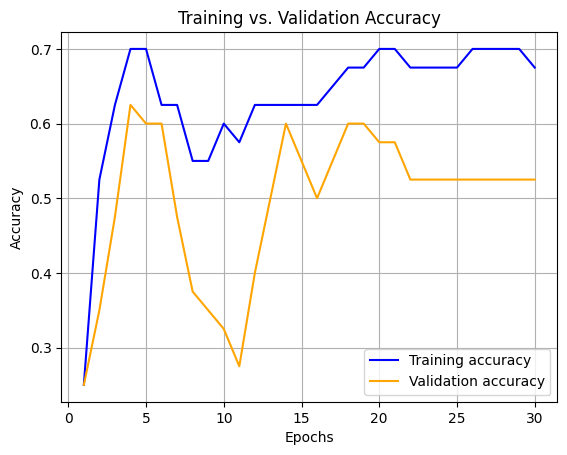

Final training accuracy: 0.675
Final validation accuracy: 0.525


In [ ]:
baseline_model = baselineANN()
train_baseline_model(baseline_model, data1=dataset3_tra, data2=dataset3_val, batch_size=250, num_epochs=30, learning_rate=0.005)

Small dataset with softmax (3 layer)

Started Training
Epoch 1: Train accuracy: 0.25, Validation accuracy: 0.25
Epoch 2: Train accuracy: 0.25, Validation accuracy: 0.25
Epoch 3: Train accuracy: 0.25, Validation accuracy: 0.25
Epoch 4: Train accuracy: 0.25, Validation accuracy: 0.25
Epoch 5: Train accuracy: 0.25, Validation accuracy: 0.25
Epoch 6: Train accuracy: 0.25, Validation accuracy: 0.25
Epoch 7: Train accuracy: 0.25, Validation accuracy: 0.25
Epoch 8: Train accuracy: 0.25, Validation accuracy: 0.25
Epoch 9: Train accuracy: 0.25, Validation accuracy: 0.25
Epoch 10: Train accuracy: 0.25, Validation accuracy: 0.25
Epoch 11: Train accuracy: 0.25, Validation accuracy: 0.25
Epoch 12: Train accuracy: 0.25, Validation accuracy: 0.25
Epoch 13: Train accuracy: 0.25, Validation accuracy: 0.25
Epoch 14: Train accuracy: 0.425, Validation accuracy: 0.475
Epoch 15: Train accuracy: 0.475, Validation accuracy: 0.375
Epoch 16: Train accuracy: 0.475, Validation accuracy: 0.35
Epoch 17: Train accuracy: 0.575, Validation accuracy: 0.575

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 250, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurre

Epoch 21: Train accuracy: 0.525, Validation accuracy: 0.6
Epoch 22: Train accuracy: 0.475, Validation accuracy: 0.5
Epoch 23: Train accuracy: 0.475, Validation accuracy: 0.5
Epoch 24: Train accuracy: 0.475, Validation accuracy: 0.4
Epoch 25: Train accuracy: 0.475, Validation accuracy: 0.325
Epoch 26: Train accuracy: 0.475, Validation accuracy: 0.325
Epoch 27: Train accuracy: 0.475, Validation accuracy: 0.275
Epoch 28: Train accuracy: 0.475, Validation accuracy: 0.275
Epoch 29: Train accuracy: 0.475, Validation accuracy: 0.275
Epoch 30: Train accuracy: 0.475, Validation accuracy: 0.25
Finished Training
Total time elapsed: 64.62 seconds


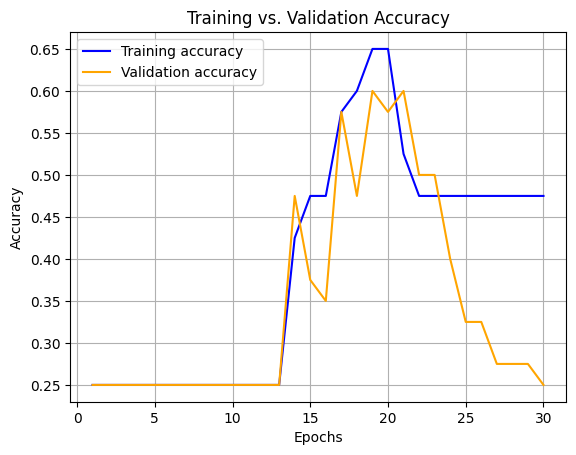

Final training accuracy: 0.475
Final validation accuracy: 0.25


In [ ]:
baseline_model = baselineANN(num_classes=4)
train_baseline_model(baseline_model, data1=dataset3_tra, data2=dataset3_val, batch_size=256, num_epochs=30, learning_rate=0.0025)

Small dataset with relu (3 layers)

Started Training
Epoch 1: Train accuracy: 0.425, Validation accuracy: 0.35
Epoch 2: Train accuracy: 0.325, Validation accuracy: 0.25
Epoch 3: Train accuracy: 0.5, Validation accuracy: 0.4
Epoch 4: Train accuracy: 0.25, Validation accuracy: 0.25
Epoch 5: Train accuracy: 0.55, Validation accuracy: 0.45
Epoch 6: Train accuracy: 0.4, Validation accuracy: 0.425
Epoch 7: Train accuracy: 0.475, Validation accuracy: 0.425
Epoch 8: Train accuracy: 0.65, Validation accuracy: 0.5
Epoch 9: Train accuracy: 0.625, Validation accuracy: 0.425
Epoch 10: Train accuracy: 0.6, Validation accuracy: 0.3
Epoch 11: Train accuracy: 0.575, Validation accuracy: 0.325
Epoch 12: Train accuracy: 0.7, Validation accuracy: 0.45
Epoch 13: Train accuracy: 0.775, Validation accuracy: 0.35
Epoch 14: Train accuracy: 0.8, Validation accuracy: 0.525
Epoch 15: Train accuracy: 0.875, Validation accuracy: 0.625
Epoch 16: Train accuracy: 0.9, Validation accuracy: 0.65
Epoch 17: Train accuracy: 0.85, Validation accuracy: 0.575
E

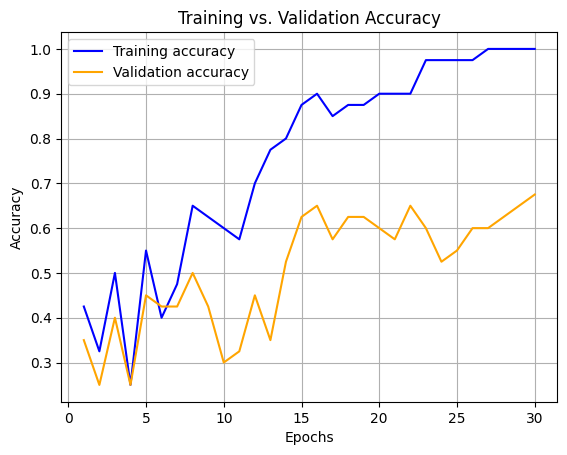

Final training accuracy: 1.0
Final validation accuracy: 0.675


In [ ]:
baseline_model = baselineANN(num_classes=4)
train_baseline_model(baseline_model, data1=dataset3_tra, data2=dataset3_val, batch_size=250, num_epochs=30, learning_rate=0.005)

Started Training
Epoch 1: Train accuracy: 0.375, Validation accuracy: 0.25
Epoch 2: Train accuracy: 0.475, Validation accuracy: 0.5
Epoch 3: Train accuracy: 0.4, Validation accuracy: 0.25
Epoch 4: Train accuracy: 0.575, Validation accuracy: 0.375
Epoch 5: Train accuracy: 0.65, Validation accuracy: 0.7
Epoch 6: Train accuracy: 0.625, Validation accuracy: 0.6
Epoch 7: Train accuracy: 0.75, Validation accuracy: 0.675
Epoch 8: Train accuracy: 0.925, Validation accuracy: 0.675
Epoch 9: Train accuracy: 0.8, Validation accuracy: 0.45
Epoch 10: Train accuracy: 0.875, Validation accuracy: 0.5
Epoch 11: Train accuracy: 0.95, Validation accuracy: 0.6
Epoch 12: Train accuracy: 0.925, Validation accuracy: 0.65
Epoch 13: Train accuracy: 0.95, Validation accuracy: 0.65
Epoch 14: Train accuracy: 0.95, Validation accuracy: 0.725
Epoch 15: Train accuracy: 1.0, Validation accuracy: 0.725
Epoch 16: Train accuracy: 1.0, Validation accuracy: 0.725
Epoch 17: Train accuracy: 1.0, Validation accuracy: 0.7
Epoc

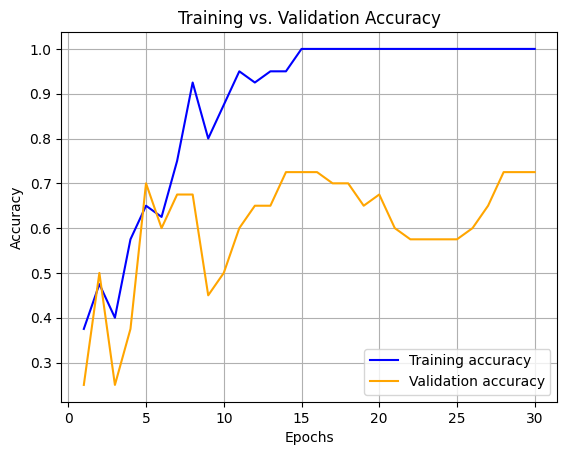

Final training accuracy: 1.0
Final validation accuracy: 0.725


In [ ]:
baseline_model = baselineANN(num_classes=4)
train_baseline_model(baseline_model, data1=dataset3_tra, data2=dataset3_val, batch_size=128, num_epochs=30, learning_rate=0.001)

Started Training
Epoch 1: Train accuracy: 0.375, Validation accuracy: 0.25
Epoch 2: Train accuracy: 0.475, Validation accuracy: 0.5
Epoch 3: Train accuracy: 0.4, Validation accuracy: 0.25
Epoch 4: Train accuracy: 0.575, Validation accuracy: 0.375
Epoch 5: Train accuracy: 0.65, Validation accuracy: 0.7
Epoch 6: Train accuracy: 0.625, Validation accuracy: 0.6
Epoch 7: Train accuracy: 0.75, Validation accuracy: 0.675
Epoch 8: Train accuracy: 0.925, Validation accuracy: 0.675
Epoch 9: Train accuracy: 0.8, Validation accuracy: 0.45
Epoch 10: Train accuracy: 0.875, Validation accuracy: 0.5
Epoch 11: Train accuracy: 0.95, Validation accuracy: 0.6
Epoch 12: Train accuracy: 0.925, Validation accuracy: 0.65
Epoch 13: Train accuracy: 0.95, Validation accuracy: 0.65
Epoch 14: Train accuracy: 0.95, Validation accuracy: 0.725
Epoch 15: Train accuracy: 1.0, Validation accuracy: 0.725
Epoch 16: Train accuracy: 1.0, Validation accuracy: 0.725
Epoch 17: Train accuracy: 1.0, Validation accuracy: 0.7
Epoc

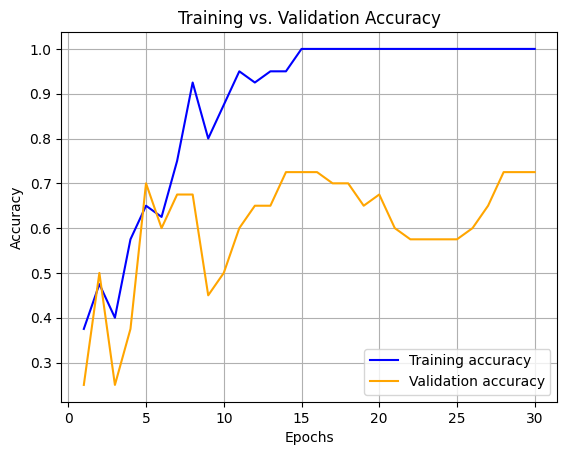

Final training accuracy: 1.0
Final validation accuracy: 0.725


In [ ]:
baseline_model = baselineANN(num_classes=4)
train_baseline_model(baseline_model, data1=dataset3_tra, data2=dataset3_val, batch_size=128, num_epochs=30, learning_rate=0.001)

Combined dataset

Started Training
Epoch 1: Train accuracy: 0.31918687589158345, Validation accuracy: 0.31187410586552217
Epoch 2: Train accuracy: 0.4917974322396576, Validation accuracy: 0.488555078683834
Epoch 3: Train accuracy: 0.5420827389443652, Validation accuracy: 0.5212804005722461
Epoch 4: Train accuracy: 0.5955777460770328, Validation accuracy: 0.5634835479256081
Epoch 5: Train accuracy: 0.5977175463623395, Validation accuracy: 0.5745708154506438
Epoch 6: Train accuracy: 0.6490727532097005, Validation accuracy: 0.6112303290414879
Epoch 7: Train accuracy: 0.6594151212553495, Validation accuracy: 0.623211731044349
Epoch 8: Train accuracy: 0.666191155492154, Validation accuracy: 0.6242846924177397
Epoch 9: Train accuracy: 0.6729671897289586, Validation accuracy: 0.6226752503576538
Epoch 10: Train accuracy: 0.6829529243937232, Validation accuracy: 0.642346208869814
Epoch 11: Train accuracy: 0.7093437945791726, Validation accuracy: 0.6341201716738197
Epoch 12: Train accuracy: 0.7203994293865906, Va

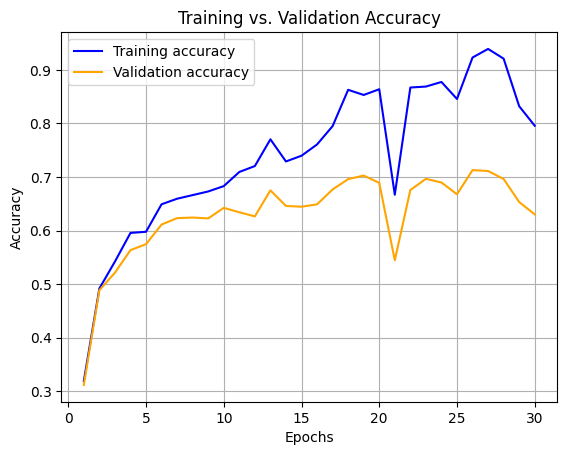

Final training accuracy: 0.7956490727532097
Final validation accuracy: 0.6301859799713877


In [ ]:
baseline_model = baselineANN(num_classes=4)
train_baseline_model(baseline_model, data1=combined_data_te, data2=combined_data_v, batch_size=250, num_epochs=30, learning_rate=0.005)

Started Training
Epoch 1: Train accuracy: 0.4975035663338088, Validation accuracy: 0.4797925608011445
Epoch 2: Train accuracy: 0.6109129814550642, Validation accuracy: 0.5840486409155937
Epoch 3: Train accuracy: 0.619472182596291, Validation accuracy: 0.5849427753934192
Epoch 4: Train accuracy: 0.6722539229671898, Validation accuracy: 0.6292918454935622
Epoch 5: Train accuracy: 0.6911554921540656, Validation accuracy: 0.6359084406294707
Epoch 6: Train accuracy: 0.7061340941512125, Validation accuracy: 0.6393061516452074
Epoch 7: Train accuracy: 0.7314550641940085, Validation accuracy: 0.6575464949928469
Epoch 8: Train accuracy: 0.7496433666191156, Validation accuracy: 0.6575464949928469
Epoch 9: Train accuracy: 0.7368045649072753, Validation accuracy: 0.6521816881258942
Epoch 10: Train accuracy: 0.7596291012838802, Validation accuracy: 0.6670243204577968
Epoch 11: Train accuracy: 0.7689015691868759, Validation accuracy: 0.674892703862661
Epoch 12: Train accuracy: 0.7860199714693296, Va

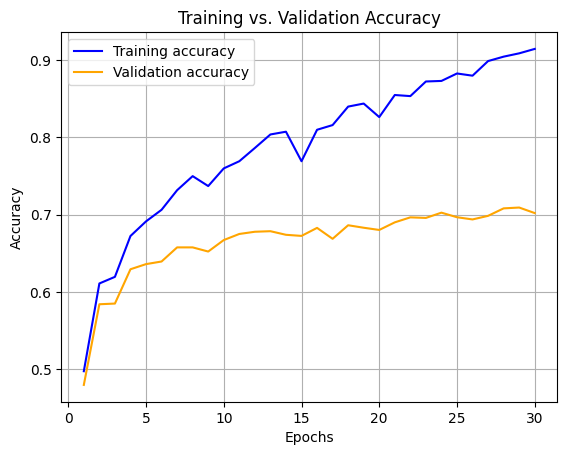

Final training accuracy: 0.9140513552068473
Final validation accuracy: 0.70189556509299


In [ ]:
baseline_model1 = baselineANN(num_classes=4)
train_baseline_model(baseline_model, data1=combined_data_te, data2=combined_data_v, batch_size=128, num_epochs=30, learning_rate=0.0001)

Started Training
Epoch 1: Train accuracy: 0.4711126961483595, Validation accuracy: 0.4678111587982833
Epoch 2: Train accuracy: 0.5723965763195435, Validation accuracy: 0.5624105865522174
Epoch 3: Train accuracy: 0.666904422253923, Validation accuracy: 0.6233905579399142
Epoch 4: Train accuracy: 0.6868758915834522, Validation accuracy: 0.6364449213161659
Epoch 5: Train accuracy: 0.7318116975748931, Validation accuracy: 0.6663090128755365
Epoch 6: Train accuracy: 0.6526390870185449, Validation accuracy: 0.5829756795422032
Epoch 7: Train accuracy: 0.6972182596291013, Validation accuracy: 0.6294706723891274
Epoch 8: Train accuracy: 0.7585592011412268, Validation accuracy: 0.6407367668097281
Epoch 9: Train accuracy: 0.764978601997147, Validation accuracy: 0.6716738197424893
Epoch 10: Train accuracy: 0.8081312410841655, Validation accuracy: 0.6849070100143062
Epoch 11: Train accuracy: 0.8569900142653353, Validation accuracy: 0.7035050071530758
Epoch 12: Train accuracy: 0.8519971469329529, Va

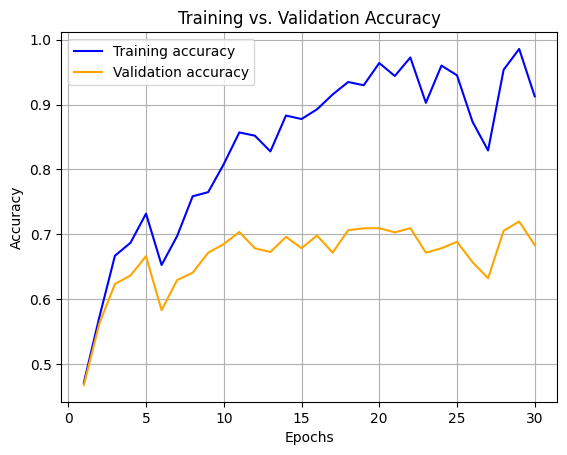

Final training accuracy: 0.9126248216833096
Final validation accuracy: 0.6832975679542204


In [ ]:
baseline_model1 = baselineANN(num_classes=4)
train_baseline_model(baseline_model1, data1=combined_data_te, data2=combined_data_v, batch_size=128, num_epochs=30, learning_rate=0.0025)